# Notes on obtaining the data

Obtain an authorization to access the dataset Genotype-Tissue Expression (GTEx) (phs000424.v8.p2) from dbGaP. Download the files as instructed, and decrypt them (see notebook "Get_datasets_from_dbGaP.ipynb" for instructions). 

GTEX dbGaP files include info on the subjects (age at death, sex, BMI, etc), as well as genotype and expression files. We do not need genotype for this analysis.

Expression files can be obtained without restriction from https://gtexportal.org/home/datasets

In particular, expression files used here are from:
https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz

Sample attribute files are here:
https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt

*In terminal:*

cd GTEX_expression_directory= '/directory/expression/GTEX/dataset'

wget https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz
gunzip GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz

wget https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt



# Setup

In [57]:
# setup
import pandas as pd
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pybiomart import Server


plt.rcParams['axes.labelweight'] = 'bold'   
plt.rcParams['axes.labelsize'] = 14  
plt.rcParams.update(plt.rcParamsDefault) #essential to be able to use ARIAL
plt.rcParams['svg.fonttype'] = 'none' #essential to be able to modify text in svg figures
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14  
plt.rcParams['font.sans-serif'] = 'Arial' # this might not work if the font Arial is not installed 

font = {'size'   : 14}
plt.rc('font', **font)    

In [44]:
# directory = '/data_set/directory/here'

dbGaP_GTEX_directory = '/directory/dbGaP/GTEX/dataset'
directory_phenotype_files = '%s/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v8.p2.c1.GRU/PhenotypeFiles' %dbGaP_GTEX_directory 
GTEX_expression_directory= '/directory/expression/GTEX/dataset'


# GTEX dataset gene expression data preparation

In this section, the expression dataset is prepared.


In [29]:
# load the subject phenotype dataset

file = 'phs000424.v8.pht002742.v8.p2.c1.GTEx_Subject_Phenotypes.GRU.txt.gz'
phenotype_subjects = pd.read_csv('%s/%s'%(directory_phenotype_files, file), skiprows=10, sep='\t', compression='gzip')
phenotype_subjects["PatientID"] = phenotype_subjects['SUBJID'].str.split('-').str[1]

extract_features = phenotype_subjects[['PatientID' ,'AGE' , 'BMI', 'SEX','DTHMNNR']]

In [51]:
# organize the GTEX expression files
# For easiness, divide the expression by tissue
# the file is big and will take a while
gtex_expre = pd.read_csv('%s/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct' %GTEX_expression_directory,  
                         sep='\t', skiprows=2)



In [53]:
# load the gene expression attributes
attributes = pd.read_csv('%s/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt' %GTEX_expression_directory,  sep='\t', error_bad_lines=False)
    
# select relevant info from the attributes file  
dictionary_attributes = {}
for i in attributes.itertuples():
    dictionary_attributes[i.SAMPID] = i.SMTSD

tissues = attributes['SMTSD'].value_counts().index    

samples= {}
for t in tissues:
    samples[t] = list(attributes[attributes['SMTSD'] == t]['SAMPID'])   


In [58]:
# retrieve correspondance of ENSEMBL gene id to gene name
# by creating a dictionary from pybiomart ensembl.org
server = Server(host='http://www.ensembl.org')
mart = server['ENSEMBL_MART_ENSEMBL']
dataset = mart['hsapiens_gene_ensembl']
genes_dictionary = dataset.query(attributes=['ensembl_gene_id','description', 'external_gene_name'])

ensID_geneName = {}
ensID_description = {}
gene_ensID={}
description_to_ensID={}
description_to_gene = {}
for i in genes_dictionary.itertuples():
#    print(i)
    ensID_geneName[i._1] = i._3
    ensID_description[i._1] = i._2
    gene_ensID[i._3]=i._1
    description_to_ensID[i._2] = i._1
    description_to_gene[i._2] = i._3


In [59]:
# annotate the GTEX expression file with geneID
gtex_expre['Gene stable ID'] = gtex_expre['Name'].str.split('.').str[0]
gtex_expre['Gene'] = gtex_expre['Gene stable ID'].map(ensID_geneName)
gtex_expre['Gene_Description'] = gtex_expre['Gene stable ID'].map(ensID_description)


In [64]:
# create individuals files with tissue expression data
columns = gtex_expre.columns
actual_samples={}
extract_samples={}
dictionary_tissues = {}
for t in tissues:
    actual_samples[t] = ['Name', 'Gene stable ID', 'Gene', 'Gene_Description']
    extract_samples[t] =[]
    for sample in samples[t]:
        if sample in columns: #not every annotated sample has GTEX expression
            actual_samples[t] = actual_samples[t] + [sample]
            extract_samples[t] = extract_samples[t] +[sample]
    dictionary_tissues[t] = gtex_expre[actual_samples[t]]
    dictionary_tissues[t].to_csv('/cluster/home/earaldi/scratch/Data/GTEX/Tissue-%s-GTEX_expression.csv' %t)

# Correlate expression of genes of interest with age

In [65]:
# select only gene and tissue of interest
gene_of_interest = 'GRHL1'

tissue = 'Muscle - Skeletal'

patients_columns = [i for i in dictionary_tissues[tissue].columns if i not in ['Unnamed: 0', 'Name', 'Gene stable ID', 'Gene', 'Gene_Description']]
array_gene_of_interest = dictionary_tissues[tissue][dictionary_tissues[tissue]['Gene'] == 'GRHL1'][patients_columns].T
index_gene = dictionary_tissues[tissue][dictionary_tissues[tissue]['Gene'] == gene_of_interest].index.values[0]
array_gene_of_interest['PatientID'] = array_gene_of_interest.index.str.split('-').str[1]
array_gene_of_interest.rename(columns = {index_gene:gene_of_interest}, inplace=True)

array_gene_of_interest['GRHL1_log2TPM'] = np.log2(array_gene_of_interest['GRHL1'])

In [89]:
#merge gene expression dataframe with patient feature dataframe

dataset = pd.merge(array_gene_of_interest, natural_causes, on ='PatientID', how='left')
dataset = dataset.dropna(subset=['SUBJID'])
dataset['tissue'] = tissue

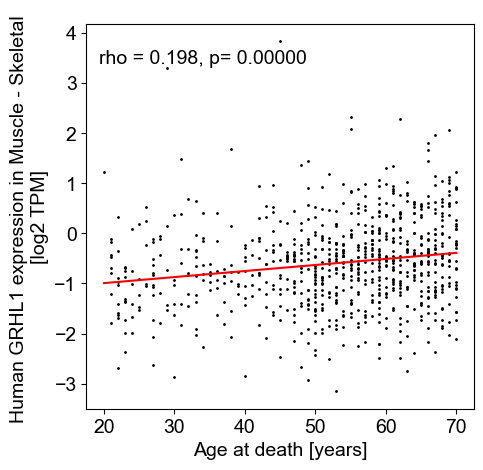

In [100]:
fig, ax = plt.subplots(figsize=(5, 5))

correlation_array = np.array(dataset[['GRHL1','AGE']])
s_r = stats.spearmanr(correlation_array[:,0], correlation_array[:,1])
     

x = np.linspace(dataset['AGE'].min(), dataset['AGE'].max(), 1000)

plt.scatter(dataset['AGE'], dataset[['GRHL1_log2TPM']], s=1, c='black')

mf, bf = np.polyfit(dataset['AGE'], dataset[['GRHL1_log2TPM']], 1) 
plt.plot(x, mf*x + bf, c='red')


plt.xlabel('Age at death [years]')
plt.ylabel('Human %s expression in %s \n[log2 TPM]' %(gene_of_interest, tissue))

plt.xticks(fontsize=14, fontname = 'Arial')
plt.yticks(fontsize=14, fontname = 'Arial')    
plt.gcf().text(0.15, 0.8,"rho = %.3f, p= %.5f"%(s_r[0],s_r[1]), fontname = 'Arial', fontsize= 14)

# plt.savefig('GTEX_Age_vs_GRHL1_expression_Spearman.svg')

plt.show()


# Exploratory Data Analysis of subjects

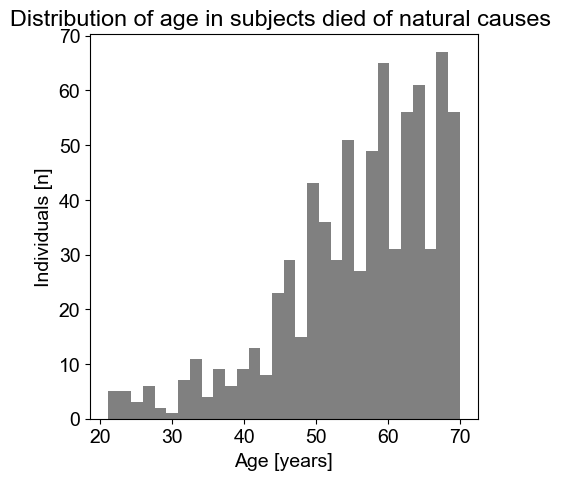

In [34]:
## Explore patients who died naturally

natural_causes = phenotype_subjects[phenotype_subjects['DTHMNNR'] == 'Natural']

fig, ax = plt.subplots(figsize=(5, 5))

plt.hist(natural_causes['AGE'], bins=30, color='Gray')
plt.xlabel("Age [years]")
plt.ylabel("Individuals [n]")
plt.title('Distribution of age in subjects died of natural causes ')
plt.show()
# plt.savefig('GTEX_histogram_natural_causes_vs_age.svg')